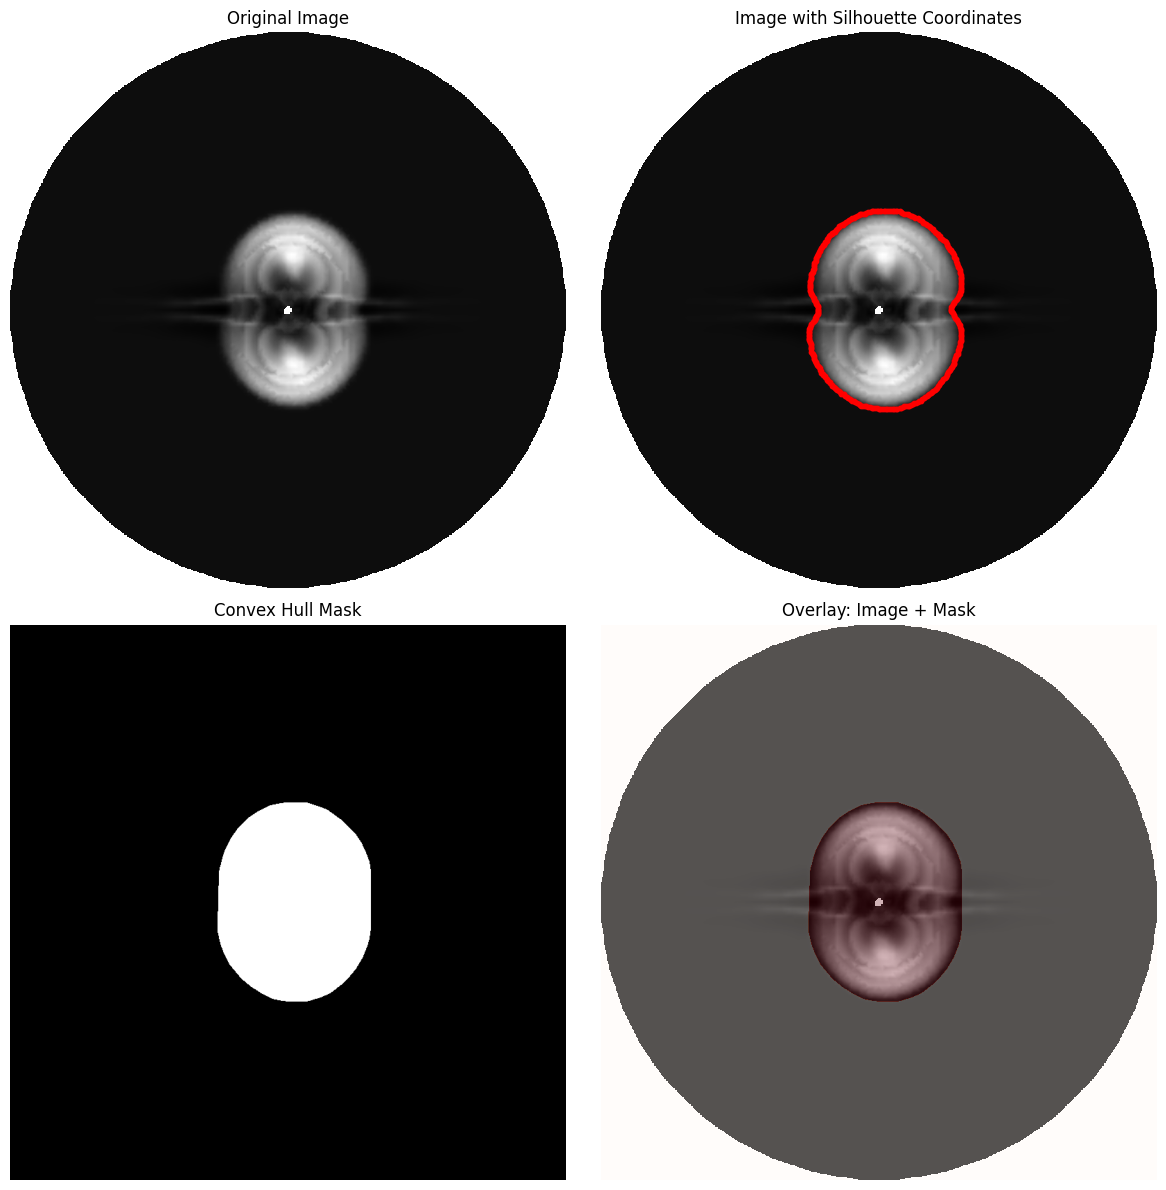

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import cv2

# Replace these paths with the actual paths to your files
npy_file = "/data/CME_Silhouettes/clean_files/All_Silhouettes/01_Fast_case/2G/Image_1003000_85.00.npy"
txt_file = "/data/CME_Silhouettes/clean_files/All_Silhouettes/01_Fast_case/2G/Silhouette_ij_T_1003000_85.00.txt"

# Load the image from the .npy file
img = np.load(npy_file)
height, width = img.shape[:2]

# ---------------------------------------------------------------------
# Read the coordinate data from the text file
# ---------------------------------------------------------------------
x_coords = []
y_coords = []
points = []
with open(txt_file, 'r') as f:
    for line in f:
        line = line.strip()
        if line:  # if line is not empty
            parts = line.split(',')
            if len(parts) == 2:
                x, y = int(parts[0]), int(parts[1])
                x_coords.append(x)
                y_coords.append(y)
                points.append((x, y))
points = np.array(points)

# ---------------------------------------------------------------------
# Compute the convex hull and create a mask from the coordinates
# ---------------------------------------------------------------------
hull = ConvexHull(points)
hull_points = points[hull.vertices]

# Create an empty mask with the same dimensions as the image
mask = np.zeros((height, width), dtype=np.uint8)
# Fill the convex polygon defined by the hull points
cv2.fillConvexPoly(mask, hull_points.astype(np.int32), 255)

# ---------------------------------------------------------------------
# Plot in a 2x2 grid:
# (0,0) - Original Image
# (0,1) - Image with Silhouette Coordinates
# (1,0) - Convex Hull Mask
# (1,1) - Overlay: Original Image with Mask (with alpha)
# ---------------------------------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# (0,0) Original Image
axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].set_title("Original Image")
axs[0, 0].axis('off')

# (0,1) Image with Silhouette Coordinates
axs[0, 1].imshow(img, cmap='gray')
axs[0, 1].scatter(x_coords, y_coords, s=10, c='red', marker='o')
axs[0, 1].set_title("Image with Silhouette Coordinates")
axs[0, 1].axis('off')

# (1,0) Convex Hull Mask
axs[1, 0].imshow(mask, cmap='gray')
axs[1, 0].set_title("Convex Hull Mask")
axs[1, 0].axis('off')

# (1,1) Overlay: Original Image with Convex Hull Mask
axs[1, 1].imshow(img, cmap='gray')
# Overlay the mask with a red colormap and a faint alpha value
axs[1, 1].imshow(mask, cmap='Reds', alpha=0.3)
axs[1, 1].set_title("Overlay: Image + Mask")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()


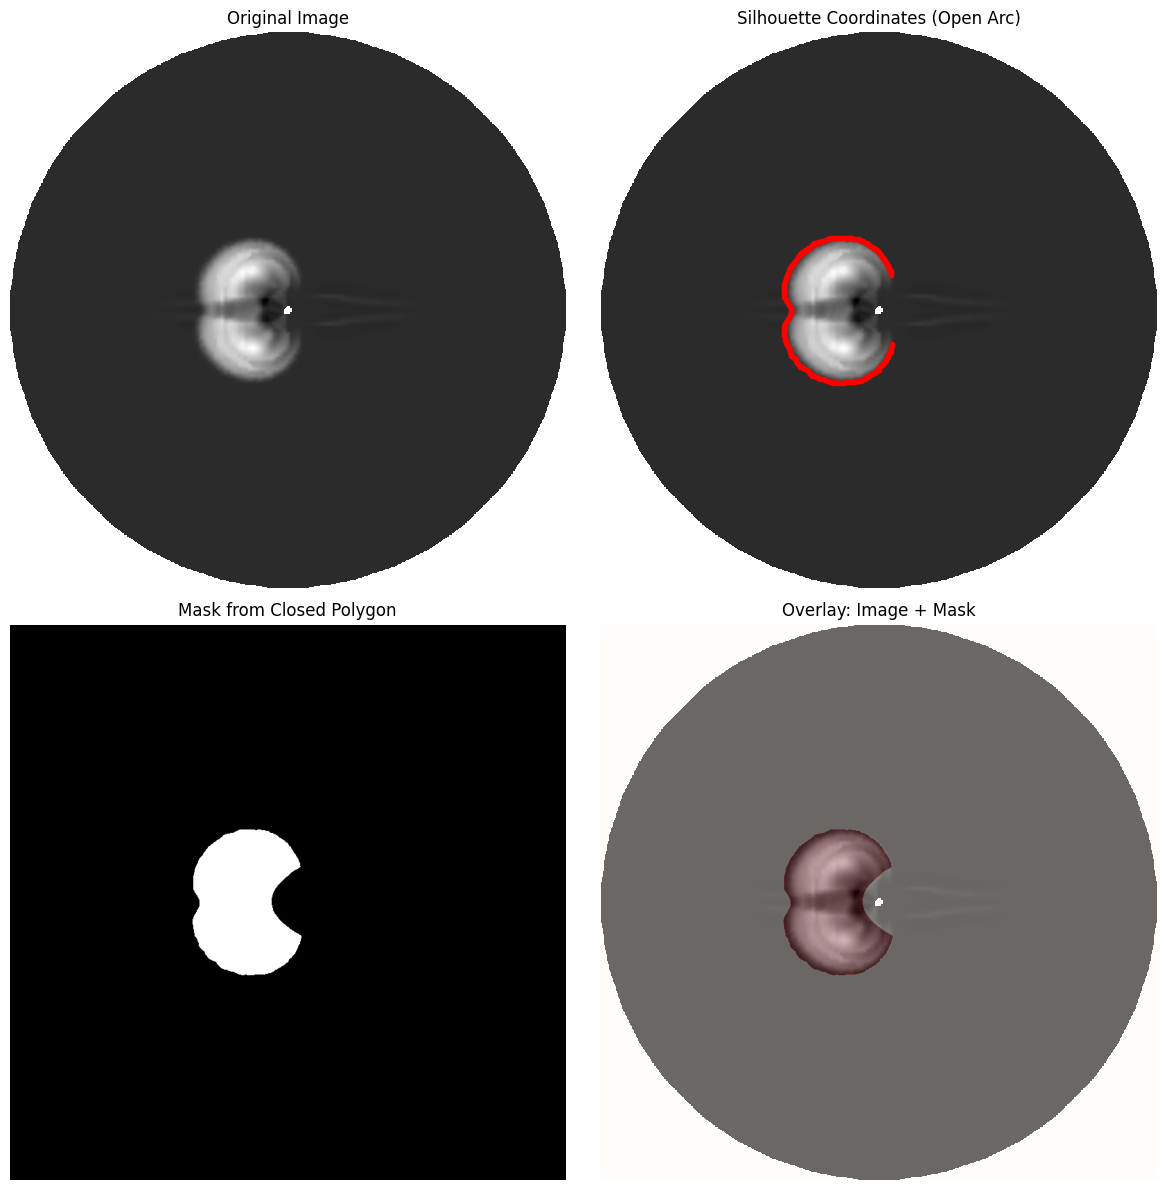

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def close_arc_inward(points, num_curve_points=10):
    """
    Given an array of ordered points (N x 2) representing an open arc,
    close the arc by connecting the last point to the first with a quadratic
    Bézier curve whose control point is the centroid of the arc.
    
    This approach forces the closure to lean inward (toward the centroid).
    """
    # Ensure the points are in float format for arithmetic
    points = points.astype(np.float32)
    p0 = points[0]
    pN = points[-1]
    
    # Compute the centroid of the arc points
    centroid = np.mean(points, axis=0)
    
    # Create a quadratic Bézier curve from pN to p0 using the centroid as control.
    # Quadratic Bézier formula: B(t) = (1-t)^2 * pN + 2*(1-t)*t * centroid + t^2 * p0, for t in [0,1]
    t_vals = np.linspace(0, 1, num_curve_points)
    bezier_curve = (
        ((1 - t_vals)**2)[:, np.newaxis] * pN +
        2 * (((1 - t_vals) * t_vals)[:, np.newaxis] * centroid) +
        ((t_vals**2)[:, np.newaxis] * p0)
    )
    
    # Combine the original arc with the closing Bézier curve.
    closed_poly = np.vstack([points, bezier_curve])
    return closed_poly

# ---------------------------------------------------------------------
# Replace these paths with your actual file paths.
npy_file = "/data/CME_Silhouettes/clean_files/All_Silhouettes/01_Fast_case/2G/Image_1002000_130.00.npy"
txt_file = "/data/CME_Silhouettes/clean_files/All_Silhouettes/01_Fast_case/2G/Silhouette_ij_T_1002000_130.00.txt"

# Load the grayscale image from the .npy file and get its dimensions.
img = np.load(npy_file)
height, width = img.shape[:2]

# ---------------------------------------------------------------------
# Read the coordinate data from the text file (ordered points along the arc)
# ---------------------------------------------------------------------
x_coords = []
y_coords = []
points_list = []
with open(txt_file, 'r') as f:
    for line in f:
        line = line.strip()
        if line:  # if line is not empty
            parts = line.split(',')
            if len(parts) == 2:
                x, y = int(parts[0]), int(parts[1])
                x_coords.append(x)
                y_coords.append(y)
                points_list.append((x, y))
points = np.array(points_list)

# ---------------------------------------------------------------------
# Create a closed polygon by connecting the open arc in an inward direction.
# ---------------------------------------------------------------------
closed_poly = close_arc_inward(points, num_curve_points=50)
# Prepare the polygon for cv2.fillPoly: shape must be (N,1,2) in int32.
poly_int = np.round(closed_poly).astype(np.int32).reshape((-1, 1, 2))

# Create a binary mask from the closed polygon.
mask = np.zeros((height, width), dtype=np.uint8)
cv2.fillPoly(mask, [poly_int], 255)

# ---------------------------------------------------------------------
# Plot a 2x2 grid:
# (0,0) - Original Image
# (0,1) - Image with Silhouette Coordinates (open arc)
# (1,0) - Mask from the Closed Polygon
# (1,1) - Overlay: Original Image with Mask (with alpha)
# ---------------------------------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# (0,0) Original Image
axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].set_title("Original Image")
axs[0, 0].axis('off')

# (0,1) Image with Silhouette Coordinates (open arc)
axs[0, 1].imshow(img, cmap='gray')
axs[0, 1].plot(x_coords, y_coords, 'r-', marker='o', markersize=3, linewidth=1)
axs[0, 1].set_title("Silhouette Coordinates (Open Arc)")
axs[0, 1].axis('off')

# (1,0) Mask from the Closed Polygon
axs[1, 0].imshow(mask, cmap='gray')
axs[1, 0].set_title("Mask from Closed Polygon")
axs[1, 0].axis('off')

# (1,1) Overlay: Original Image with Mask (using simple overlay)
axs[1, 1].imshow(img, cmap='gray')
# Overlay the mask with a red colormap and a faint alpha value
axs[1, 1].imshow(mask, cmap='Reds', alpha=0.3)
axs[1, 1].set_title("Overlay: Image + Mask")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()


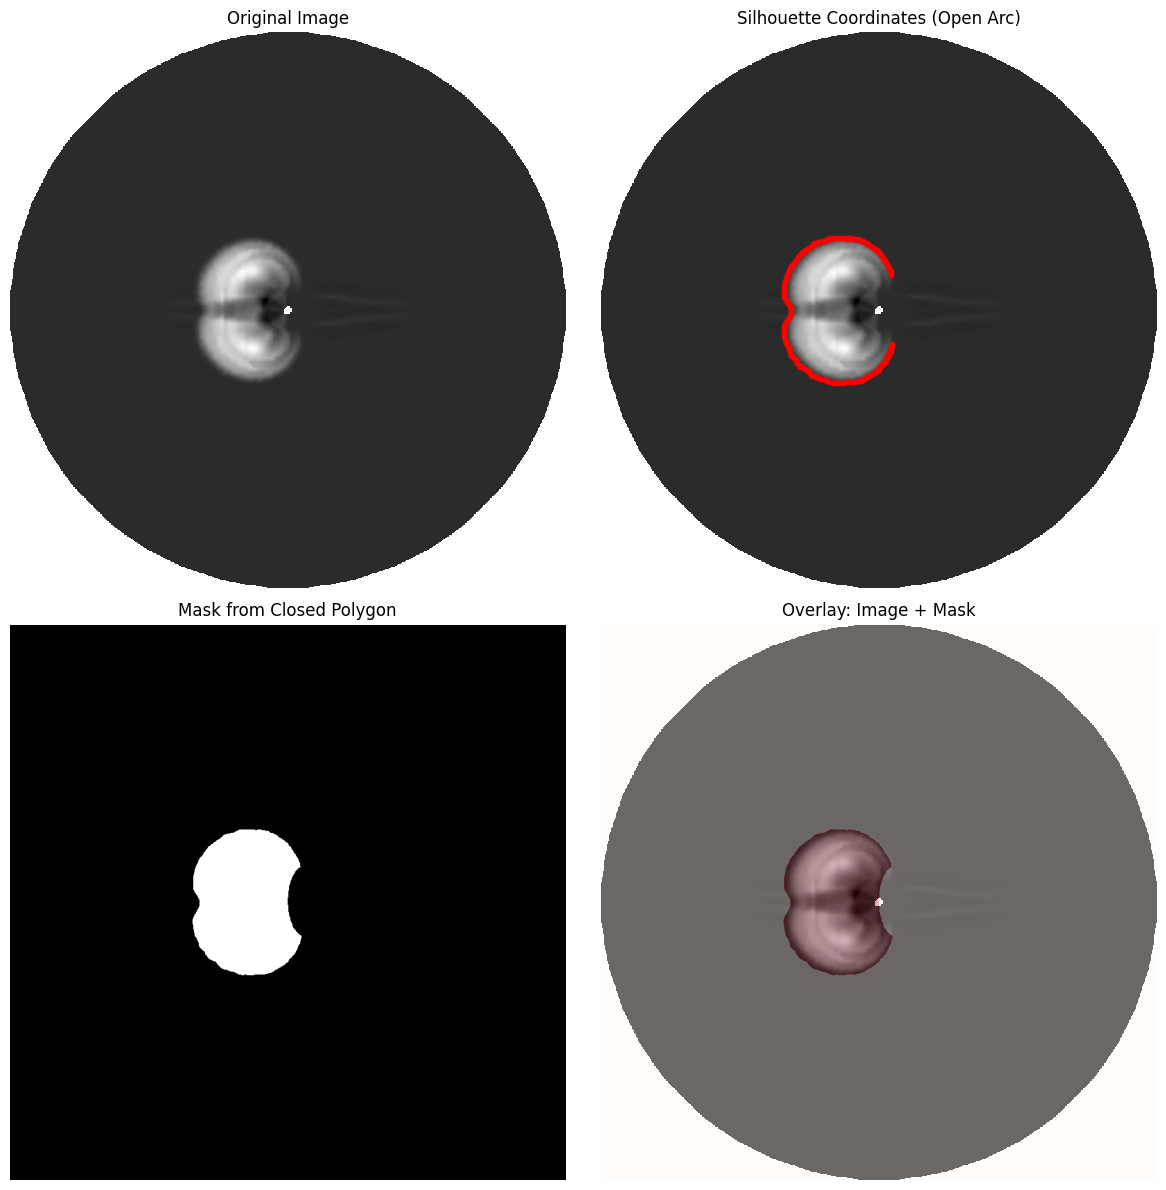

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def close_arc_inward_cubic(points, num_curve_points=50, frac=0.3):
    """
    Given an array of ordered points (N x 2) representing an open arc,
    close the arc by connecting the last point to the first with a cubic
    Bézier curve that leans inward (toward the centroid of the arc).
    
    The cubic Bézier curve is defined as:
      B(t) = (1-t)^3 * p_N + 3*(1-t)^2*t * P1 + 3*(1-t)*t^2 * P2 + t^3 * p_0,  t in [0,1]
    
    Control points are chosen as:
      P1 = p_N + frac*(C - p_N)
      P2 = p_0 + frac*(C - p_0)
    where p_N is the last point, p_0 is the first point, C is the centroid, 
    and frac is a fraction (e.g. 0.3).
    """
    # Ensure points are float for arithmetic.
    points = points.astype(np.float32)
    p0 = points[0]
    pN = points[-1]
    
    # Compute centroid of the arc points.
    centroid = np.mean(points, axis=0)
    
    # Determine control points.
    P1 = pN + frac * (centroid - pN)
    P2 = p0 + frac * (centroid - p0)
    
    # Sample t values.
    t_vals = np.linspace(0, 1, num_curve_points)
    
    # Compute the cubic Bézier curve.
    bezier_curve = (
        ((1 - t_vals)**3)[:, np.newaxis] * pN +
        (3 * ((1 - t_vals)**2) * t_vals)[:, np.newaxis] * P1 +
        (3 * (1 - t_vals) * (t_vals**2))[:, np.newaxis] * P2 +
        (t_vals**3)[:, np.newaxis] * p0
    )
    
    # Combine the original arc with the closing Bézier curve.
    closed_poly = np.vstack([points, bezier_curve])
    return closed_poly

# ---------------------------------------------------------------------
# Replace these paths with your actual file paths.
npy_file = "/data/CME_Silhouettes/clean_files/All_Silhouettes/01_Fast_case/2G/Image_1002000_130.00.npy"
txt_file = "/data/CME_Silhouettes/clean_files/All_Silhouettes/01_Fast_case/2G/Silhouette_ij_T_1002000_130.00.txt"

# Load the grayscale image from the .npy file and get its dimensions.
img = np.load(npy_file)
height, width = img.shape[:2]

# ---------------------------------------------------------------------
# Read the coordinate data from the text file (ordered points along the arc)
# ---------------------------------------------------------------------
x_coords = []
y_coords = []
points_list = []
with open(txt_file, 'r') as f:
    for line in f:
        line = line.strip()
        if line:  # if line is not empty
            parts = line.split(',')
            if len(parts) == 2:
                x, y = int(parts[0]), int(parts[1])
                x_coords.append(x)
                y_coords.append(y)
                points_list.append((x, y))
points = np.array(points_list)

# ---------------------------------------------------------------------
# Create a closed polygon by connecting the open arc in an inward direction using a cubic Bézier curve.
# ---------------------------------------------------------------------
closed_poly = close_arc_inward_cubic(points, num_curve_points=50, frac=0.3)
# Prepare the polygon for cv2.fillPoly: shape must be (N,1,2) in int32.
poly_int = np.round(closed_poly).astype(np.int32).reshape((-1, 1, 2))

# Create a binary mask from the closed polygon.
mask = np.zeros((height, width), dtype=np.uint8)
cv2.fillPoly(mask, [poly_int], 255)

# ---------------------------------------------------------------------
# Plot a 2x2 grid:
# (0,0) - Original Image
# (0,1) - Image with Silhouette Coordinates (open arc)
# (1,0) - Mask from the Closed Polygon
# (1,1) - Overlay: Original Image with Mask (with alpha)
# ---------------------------------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# (0,0) Original Image
axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].set_title("Original Image")
axs[0, 0].axis('off')

# (0,1) Image with Silhouette Coordinates (open arc)
axs[0, 1].imshow(img, cmap='gray')
axs[0, 1].plot(x_coords, y_coords, 'r-', marker='o', markersize=3, linewidth=1)
axs[0, 1].set_title("Silhouette Coordinates (Open Arc)")
axs[0, 1].axis('off')

# (1,0) Mask from the Closed Polygon
axs[1, 0].imshow(mask, cmap='gray')
axs[1, 0].set_title("Mask from Closed Polygon")
axs[1, 0].axis('off')

# (1,1) Overlay: Original Image with Mask (using the simple overlay technique)
axs[1, 1].imshow(img, cmap='gray')
# Overlay the mask with a red colormap and a faint alpha value.
axs[1, 1].imshow(mask, cmap='Reds', alpha=0.3)
axs[1, 1].set_title("Overlay: Image + Mask")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()


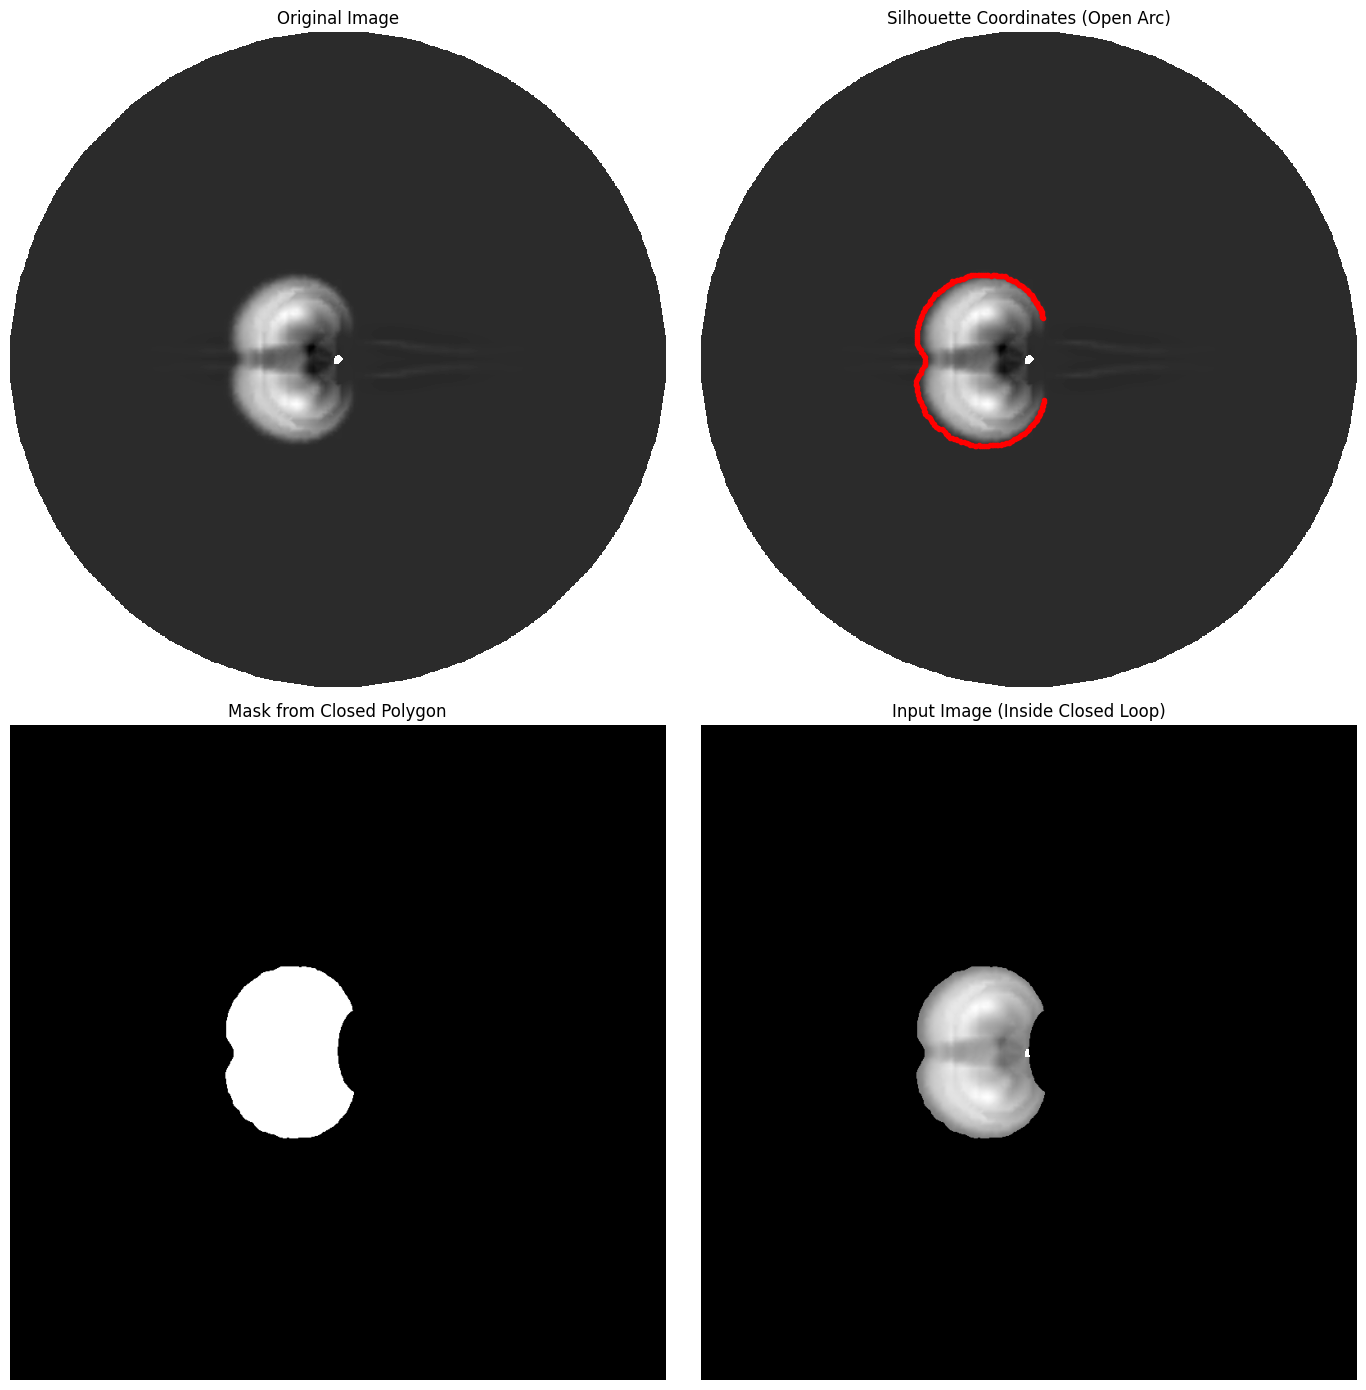

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def close_arc_inward_cubic(points, num_curve_points=50, frac=0.3):
    """
    Given an array of ordered points (N x 2) representing an open arc,
    close the arc by connecting the last point to the first with a cubic
    Bézier curve that leans inward (toward the centroid of the arc).
    
    The cubic Bézier curve is defined as:
      B(t) = (1-t)^3 * p_N + 3*(1-t)^2*t * P1 + 3*(1-t)*t^2 * P2 + t^3 * p_0,  t in [0,1]
    
    Control points are chosen as:
      P1 = p_N + frac*(C - p_N)
      P2 = p_0 + frac*(C - p_0)
    where p_N is the last point, p_0 is the first point, C is the centroid, 
    and frac is a fraction (e.g. 0.3).
    """
    # Ensure points are float for arithmetic.
    points = points.astype(np.float32)
    p0 = points[0]
    pN = points[-1]
    
    # Compute centroid of the arc points.
    centroid = np.mean(points, axis=0)
    
    # Determine control points.
    P1 = pN + frac * (centroid - pN)
    P2 = p0 + frac * (centroid - p0)
    
    # Sample t values.
    t_vals = np.linspace(0, 1, num_curve_points)
    
    # Compute the cubic Bézier curve.
    bezier_curve = (
        ((1 - t_vals)**3)[:, np.newaxis] * pN +
        (3 * ((1 - t_vals)**2) * t_vals)[:, np.newaxis] * P1 +
        (3 * (1 - t_vals) * (t_vals**2))[:, np.newaxis] * P2 +
        ((t_vals**3))[:, np.newaxis] * p0
    )
    
    # Combine the original arc with the closing Bézier curve.
    closed_poly = np.vstack([points, bezier_curve])
    return closed_poly

def create_mask_from_txt_cubic(txt_file, shape):
    """
    Reads the pixel coordinates from a txt file, closes the open arc using
    a cubic Bézier curve that leans inward, and generates a binary mask
    by filling the resulting polygon.
    """
    points = []
    with open(txt_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                parts = line.split(',')
                if len(parts) == 2:
                    try:
                        x, y = int(parts[0]), int(parts[1])
                        points.append([x, y])
                    except ValueError:
                        continue
    if len(points) == 0:
        return np.zeros(shape, dtype=np.uint8)
    
    points = np.array(points)
    
    # Use the cubic Bézier method to close the arc.
    closed_poly = close_arc_inward_cubic(points, num_curve_points=50, frac=0.3)
    
    # Prepare the polygon for cv2.fillPoly (needs shape (N,1,2) and int32).
    poly_int = np.round(closed_poly).astype(np.int32).reshape((-1, 1, 2))
    
    mask = np.zeros(shape, dtype=np.uint8)
    cv2.fillPoly(mask, [poly_int], 255)
    
    # Return mask as uint8 with values 0 and 255.
    return mask

# ---------------------------------------------------------------------
# Replace these paths with your actual file paths.
npy_file = "/data/CME_Silhouettes/clean_files/All_Silhouettes/01_Fast_case/2G/Image_1002000_130.00.npy"
txt_file = "/data/CME_Silhouettes/clean_files/All_Silhouettes/01_Fast_case/2G/Silhouette_ij_T_1002000_130.00.txt"

# Load the grayscale image from the .npy file and get its dimensions.
img = np.load(npy_file)  # shape (801,801), dtype=uint8
height, width = img.shape[:2]

# Read coordinate data from the text file.
x_coords = []
y_coords = []
points_list = []
with open(txt_file, 'r') as f:
    for line in f:
        line = line.strip()
        if line:  # if line is not empty
            parts = line.split(',')
            if len(parts) == 2:
                x, y = int(parts[0]), int(parts[1])
                x_coords.append(x)
                y_coords.append(y)
                points_list.append((x, y))
points = np.array(points_list)

# Create a closed polygon using the cubic Bézier curve.
closed_poly = close_arc_inward_cubic(points, num_curve_points=50, frac=0.3)
poly_int = np.round(closed_poly).astype(np.int32).reshape((-1, 1, 2))

# Create a binary mask by filling the closed polygon.
mask = np.zeros((height, width), dtype=np.uint8)
cv2.fillPoly(mask, [poly_int], 255)

# --- NEW STEP: Extract only the image regions within the closed loop ---
# Here we select only the non-zero (inside) regions from the original image.
# Using bitwise_and: Only pixels where mask==255 are kept.
img_inside = cv2.bitwise_and(img, img, mask=mask)

# Plot the results.
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

# (0,0) Original Image.
axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].set_title("Original Image")
axs[0, 0].axis('off')

# (0,1) Open Arc (Silhouette Coordinates).
axs[0, 1].imshow(img, cmap='gray')
axs[0, 1].plot(x_coords, y_coords, 'r-', marker='o', markersize=3, linewidth=1)
axs[0, 1].set_title("Silhouette Coordinates (Open Arc)")
axs[0, 1].axis('off')

# (1,0) Binary Mask (Closed Polygon).
axs[1, 0].imshow(mask, cmap='gray')
axs[1, 0].set_title("Mask from Closed Polygon")
axs[1, 0].axis('off')

# (1,1) Image with Only the Region Inside the Closed Loop.
axs[1, 1].imshow(img_inside, cmap='gray')
axs[1, 1].set_title("Input Image (Inside Closed Loop)")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()
